In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Add, Input, Dense, Reshape, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, BatchNormalization
from keras.engine.topology import Layer, InputSpec
import os
import random
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn import metrics

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!nvidia-smi

Wed Apr 22 03:37:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |     11MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
sampgen = ImageDataGenerator(
    preprocessing_function=np.log)

In [5]:
dir_names = ["GBT_58202_60970_B0329+54_fine", "GBT_58307_26947_J1935+1616_fine", "GBT_58210_37805_HIP103730_fine", "GBT_58452_79191_HIP115687_fine"]

In [6]:
x_samp = np.empty((800*32, 16, 200, 1))
for shift, directory in enumerate(dir_names):
    gen = sampgen.flow_from_directory(
        directory=f"../../data/S-band/{directory}/filtered",
        target_size=(16, 200),
        color_mode="grayscale",
        class_mode="input"
    )
    for i in tqdm(range(200)):
        x_samp[(shift*200+i)*32:(shift*200+i+1)*32] = gen.next()[0]

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 66973 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 77.43it/s]


Found 70384 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.45it/s]


Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 75.51it/s]


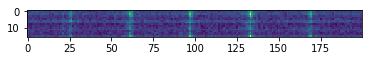

In [7]:
plt.imshow(x_samp[16, :, :, 0])

In [8]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    preprocessing_function=np.log)
datagen.fit(x_samp)

In [9]:
def res_conv_block(inp, units, num_layers, activ="relu"):
    x = inp
    for i in range(num_layers):
        x = Conv2D(units, (3, 3), activation=activ, padding="same")(x)
    return Add()([x, inp])

def res_deconv_block(inp, units, num_layers, activ="relu"):
    x = inp
    for i in range(num_layers):
        x = Conv2DTranspose(units, (3, 3), activation=activ, padding="same")(x)
    return Add()([x, inp])

In [10]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

In [13]:
n_clusters = 11

input_img = Input(shape=(16, 200, 1))
x = res_conv_block(input_img, 64, 2)

pool_1 = MaxPooling2D((1, 2), padding="same")(x)
x = res_conv_block(pool_1, 64, 2)

pool_2 = MaxPooling2D((2, 2), padding="same")(x)
x = res_conv_block(pool_2, 64, 2)

x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)


flat = Flatten()(x)
x = Dense(256, activation='relu')(flat)
encoded = Dense(64, activation='relu', name="encoded")(x)
x = Dense(256, activation='relu')(encoded)
x = Dense(800, activation='relu')(x)
x = Reshape((4, 25, 8))(x)

x = UpSampling2D((2, 2))(x)
up_1 = Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)

x = res_deconv_block(up_1, 64, 2)
up_2 = UpSampling2D((2, 2))(x)

x = res_deconv_block(up_2, 64, 2)
up_3 = UpSampling2D((1, 2))(x)

x = res_deconv_block(up_3, 64, 2)
decoded = Conv2DTranspose(1, (3, 3), padding="same", name="decoded")(x)

autoencoder, encoder = Model(inputs=input_img, outputs=decoded, name="autoencoder"), Model(inputs=input_img, outputs=encoded, name="encoder")
clustering_layer = ClusteringLayer(n_clusters, name='clustering_layer')(encoder.output)
idec = Model(inputs=autoencoder.input, outputs=[clustering_layer, decoded])


In [14]:
idec.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16, 200, 1)   0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 16, 200, 64)  640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 200, 64)  36928       conv2d_11[0][0]                  
__________________________________________________________________________________________________
add_7 (Add)                     (None, 16, 200, 64)  0           conv2d_12[0][0]                  
                                                                 input_2[0][0]              

In [15]:
print(" Start Autoencoder Training ".center(60, "-"), end="\n\n")
autoencoder.compile("adam", loss="mse")
histories = defaultdict(list)

for i in range(4):
    print(f" Training Iteration {i} ".center(60, "-"), end="\n\n")
    for dir_name in dir_names:
        print(f"Training on {dir_name}")
        training_history = autoencoder.fit_generator(generator=datagen.flow_from_directory(
            directory=f"../../data/S-band/{dir_name}/filtered",
            target_size=(16, 200),
            color_mode="grayscale",
            class_mode="input"
        ), epochs=5)
        histories[dir_name].append(training_history)

---------------- Start Autoencoder Training ----------------

------------------- Training Iteration 0 -------------------

Training on GBT_58202_60970_B0329+54_fine
Found 48472 images belonging to 11 classes.
Epoch 1/5
1515/1515 [==============================] - 69s 46ms/step - loss: 0.3918
Epoch 2/5
1515/1515 [==============================] - 68s 45ms/step - loss: 0.3040
Epoch 3/5
1515/1515 [==============================] - 68s 45ms/step - loss: 0.2902
Epoch 4/5
1515/1515 [==============================] - 68s 45ms/step - loss: 0.2815
Epoch 5/5
1515/1515 [==============================] - 68s 45ms/step - loss: 0.2734
Training on GBT_58307_26947_J1935+1616_fine
Found 66973 images belonging to 11 classes.
Epoch 1/5
2093/2093 [==============================] - 94s 45ms/step - loss: 0.2374
Epoch 2/5
2093/2093 [==============================] - 93s 44ms/step - loss: 0.2190
Epoch 3/5
2093/2093 [==============================] - 93s 44ms/step - loss: 0.2118
Epoch 4/5
2093/2093 [=========

2406/2406 [==============================] - 105s 44ms/step - loss: 0.1740
Epoch 4/5
2406/2406 [==============================] - 105s 44ms/step - loss: 0.1723
Epoch 5/5
2406/2406 [==============================] - 105s 44ms/step - loss: 0.1712


In [16]:
def fit_cluster(model, x, y=None, gamma=0.1, maxiter=3200, batch_size=64, tol=1e-3, update_interval=200, cold_start=False):
    if cold_start:
        model.compile(loss={'clustering_layer': 'kld', 'decoded': 'mse'},
                        loss_weights={'clustering_layer': gamma, 'decoded': 1},
                        optimizer="adam")
        print(' Initializing cluster centers with k-means '.center(60, "-"), end="\n\n")
        kmeans = KMeans(n_clusters)
        y_pred = kmeans.fit_predict(encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        model.get_layer(name='clustering_layer').set_weights([kmeans.cluster_centers_])
        print(" Model Compiled and Initialized ".center(60, "-"), end="\n\n")
    else:
        q, _ = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p
        y_pred_last = q.argmax(1)
        y_pred = None
    
    index = 0
    index_array = np.arange(x.shape[0])
    
    for ite in range(int(maxiter)):
        if ite % update_interval == 0:
            q, _ = model.predict(x, verbose=0)
            p = target_distribution(q)  # update the auxiliary target distribution p
            y_pred = q.argmax(1)
            delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
            y_pred_last = np.copy(y_pred)
            
            if y is not None:
                acc = np.round(np.count_nonzero(y==y_pred) / y_pred.shape[0], 5)
                nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
                ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
                print(f"\nAccuracy: {acc}, NMI: {nmi}, ARI: {ari}")
            
            if ite > 0 and delta_label < tol:
                    print(f"delta_label {delta_label} < {tol}")
                    print('Reached tolerance threshold. Stopping training.'.center(60, "-"), end="\n\n")
                    break
                    
        idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
        total_loss, clustering_loss, reconstruction_loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
        print(f"\rIteration {ite:>5}, Total Loss: {total_loss:.5f}, Cluster Loss: {clustering_loss:.5f}, Reconstruction Loss {reconstruction_loss:.5f}", end="", flush=True)
        if ite % update_interval == 0:
            print()
            
    print()
    print(" Saving Model ".center(60, "-"), end="\n\n")
    from datetime import datetime
    timestamp = datetime.now().strftime("%d-%m-%y-%H:%M")
    print("timestamp =", timestamp)

    model_name = "idec"
    # serialize model to JSON
    model_json = model.to_json()
    with open(f"models/{model_name}-{timestamp}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"models/{model_name}-{timestamp}.h5")
    print("Saved model to disk")
    
    return y_pred

In [17]:
num_batch_each = 200
x_cluster_samp = np.empty((num_batch_each*len(dir_names)*32, 16, 200, 1))
y_cluster_samp = np.empty((num_batch_each*len(dir_names)*32))
for shift, directory in enumerate(dir_names):
    gen = datagen.flow_from_directory(
        directory=f"../../data/S-band/{directory}/filtered",
        target_size=(16, 200),
        color_mode="grayscale",
        class_mode="sparse"
    )
    for i in tqdm(range(num_batch_each)):
        temp_x, temp_y = gen.next()
        x_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_x
        y_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_y

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 79.38it/s]


In [18]:
print(" Start Joint Training ".center(60, "-"), end="\n\n")
fit_cluster(idec, x_cluster_samp, y_cluster_samp, cold_start=True)
for i in range(19):
    num_batch_each = 200
    x_cluster_samp = np.empty((num_batch_each*len(dir_names)*32, 16, 200, 1))
    y_cluster_samp = np.empty((num_batch_each*len(dir_names)*32))
    for shift, directory in enumerate(dir_names):
        gen = datagen.flow_from_directory(
            directory=f"../../data/S-band/{directory}/filtered",
            target_size=(16, 200),
            color_mode="grayscale",
            class_mode="sparse"
        )
        for i in tqdm(range(num_batch_each)):
            temp_x, temp_y = gen.next()
            x_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_x
            y_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_y
            
    fit_cluster(idec, x_cluster_samp, y_cluster_samp)

------------------- Start Joint Training -------------------

-------- Initializing cluster centers with k-means ---------

-------------- Model Compiled and Initialized --------------


Accuracy: 0.12711, NMI: 0.08652, ARI: -0.02885
Iteration     0, Total Loss: 0.29233, Cluster Loss: 0.11117, Reconstruction Loss 0.28121
Iteration   199, Total Loss: 0.13816, Cluster Loss: 0.02905, Reconstruction Loss 0.13525
Accuracy: 0.11449, NMI: 0.08619, ARI: -0.0249
Iteration   200, Total Loss: 0.15013, Cluster Loss: 0.14406, Reconstruction Loss 0.13572
Iteration   399, Total Loss: 0.12316, Cluster Loss: 0.05294, Reconstruction Loss 0.11786
Accuracy: 0.11406, NMI: 0.08676, ARI: -0.02088
Iteration   400, Total Loss: 0.13334, Cluster Loss: 0.16288, Reconstruction Loss 0.11706
Iteration   599, Total Loss: 0.11312, Cluster Loss: 0.07575, Reconstruction Loss 0.10554
Accuracy: 0.11637, NMI: 0.08616, ARI: -0.01851
Iteration   600, Total Loss: 0.12181, Cluster Loss: 0.15289, Reconstruction Loss 0.10652
Ite

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 66973 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.99it/s]


Found 70384 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.94it/s]


Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 72.57it/s]



Accuracy: 0.12457, NMI: 0.08919, ARI: -0.00865
Iteration     0, Total Loss: 0.66229, Cluster Loss: 0.16284, Reconstruction Loss 0.64601
Iteration   199, Total Loss: 0.16505, Cluster Loss: 0.08184, Reconstruction Loss 0.15687
Accuracy: 0.12445, NMI: 0.09054, ARI: -0.00786
Iteration   200, Total Loss: 0.17243, Cluster Loss: 0.15707, Reconstruction Loss 0.15672
Iteration   399, Total Loss: 0.14706, Cluster Loss: 0.07667, Reconstruction Loss 0.13940
Accuracy: 0.12137, NMI: 0.09198, ARI: -0.00622
Iteration   400, Total Loss: 0.15175, Cluster Loss: 0.12738, Reconstruction Loss 0.13901
Iteration   599, Total Loss: 0.13483, Cluster Loss: 0.07565, Reconstruction Loss 0.12726
Accuracy: 0.12059, NMI: 0.09176, ARI: -0.00578
Iteration   600, Total Loss: 0.13844, Cluster Loss: 0.10921, Reconstruction Loss 0.12752
Iteration   799, Total Loss: 0.13237, Cluster Loss: 0.07794, Reconstruction Loss 0.12457
Accuracy: 0.12098, NMI: 0.09173, ARI: -0.0064
Iteration   800, Total Loss: 0.13517, Cluster Loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 66973 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.10it/s]


Found 70384 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 79.64it/s]



Accuracy: 0.12594, NMI: 0.08978, ARI: -0.01119
Iteration     0, Total Loss: 0.71002, Cluster Loss: 0.15737, Reconstruction Loss 0.69428
Iteration   199, Total Loss: 0.17582, Cluster Loss: 0.06836, Reconstruction Loss 0.16899
Accuracy: 0.12301, NMI: 0.08775, ARI: -0.01424
Iteration   200, Total Loss: 0.18101, Cluster Loss: 0.12031, Reconstruction Loss 0.16898
Iteration   399, Total Loss: 0.15367, Cluster Loss: 0.05648, Reconstruction Loss 0.14803
Accuracy: 0.12742, NMI: 0.0889, ARI: -0.01427
Iteration   400, Total Loss: 0.15662, Cluster Loss: 0.08553, Reconstruction Loss 0.14807
Iteration   599, Total Loss: 0.14095, Cluster Loss: 0.05856, Reconstruction Loss 0.13509
Accuracy: 0.12695, NMI: 0.08808, ARI: -0.01433
Iteration   600, Total Loss: 0.14201, Cluster Loss: 0.07106, Reconstruction Loss 0.13491
Iteration   799, Total Loss: 0.13325, Cluster Loss: 0.05799, Reconstruction Loss 0.12745
Accuracy: 0.12797, NMI: 0.08871, ARI: -0.01468
Iteration   800, Total Loss: 0.13390, Cluster Loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 66973 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.31it/s]


Found 70384 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.57it/s]


Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 79.50it/s]



Accuracy: 0.12305, NMI: 0.08878, ARI: -0.01457
Iteration     0, Total Loss: 0.51619, Cluster Loss: 0.10902, Reconstruction Loss 0.50529
Iteration   199, Total Loss: 0.18485, Cluster Loss: 0.04110, Reconstruction Loss 0.18074
Accuracy: 0.11586, NMI: 0.08057, ARI: -0.01905
Iteration   200, Total Loss: 0.19152, Cluster Loss: 0.08892, Reconstruction Loss 0.18263
Iteration   399, Total Loss: 0.16656, Cluster Loss: 0.04077, Reconstruction Loss 0.16248
Accuracy: 0.11621, NMI: 0.08018, ARI: -0.02061
Iteration   400, Total Loss: 0.16936, Cluster Loss: 0.07048, Reconstruction Loss 0.16231
Iteration   599, Total Loss: 0.15778, Cluster Loss: 0.04585, Reconstruction Loss 0.15320
Accuracy: 0.11594, NMI: 0.07927, ARI: -0.0199
Iteration   600, Total Loss: 0.15987, Cluster Loss: 0.05460, Reconstruction Loss 0.15441
Iteration   799, Total Loss: 0.14998, Cluster Loss: 0.04546, Reconstruction Loss 0.14543
Accuracy: 0.1143, NMI: 0.07699, ARI: -0.02169
Iteration   800, Total Loss: 0.14870, Cluster Loss: 0.

  0%|          | 0/200 [00:00<?, ?it/s]

Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.55it/s]



Accuracy: 0.11496, NMI: 0.07096, ARI: -0.02801
Iteration     0, Total Loss: 0.56784, Cluster Loss: 0.12630, Reconstruction Loss 0.55521
Iteration   199, Total Loss: 0.21725, Cluster Loss: 0.04937, Reconstruction Loss 0.21232
Accuracy: 0.12348, NMI: 0.06889, ARI: -0.0242
Iteration   200, Total Loss: 0.22251, Cluster Loss: 0.09450, Reconstruction Loss 0.21306
Iteration   399, Total Loss: 0.18081, Cluster Loss: 0.05052, Reconstruction Loss 0.17576
Accuracy: 0.12957, NMI: 0.07284, ARI: -0.02179
Iteration   400, Total Loss: 0.18323, Cluster Loss: 0.07279, Reconstruction Loss 0.17595
Iteration   599, Total Loss: 0.16498, Cluster Loss: 0.05041, Reconstruction Loss 0.15994
Accuracy: 0.13109, NMI: 0.07229, ARI: -0.02143
Iteration   600, Total Loss: 0.16607, Cluster Loss: 0.05936, Reconstruction Loss 0.16014
Iteration   799, Total Loss: 0.15470, Cluster Loss: 0.05102, Reconstruction Loss 0.14960
Accuracy: 0.1325, NMI: 0.07201, ARI: -0.02097
Iteration   800, Total Loss: 0.15416, Cluster Loss: 0.

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.96it/s]


Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 77.70it/s]



Accuracy: 0.13371, NMI: 0.06857, ARI: -0.02031
Iteration     0, Total Loss: 0.47218, Cluster Loss: 0.10520, Reconstruction Loss 0.46166
Iteration   199, Total Loss: 0.19971, Cluster Loss: 0.03172, Reconstruction Loss 0.19654
Accuracy: 0.13371, NMI: 0.06186, ARI: -0.02351
Iteration   200, Total Loss: 0.20302, Cluster Loss: 0.06854, Reconstruction Loss 0.19616
Iteration   399, Total Loss: 0.18399, Cluster Loss: 0.02421, Reconstruction Loss 0.18157
Accuracy: 0.13422, NMI: 0.06216, ARI: -0.02419
Iteration   400, Total Loss: 0.18524, Cluster Loss: 0.03797, Reconstruction Loss 0.18145
Iteration   599, Total Loss: 0.17535, Cluster Loss: 0.02482, Reconstruction Loss 0.17287
Accuracy: 0.13301, NMI: 0.06154, ARI: -0.02517
Iteration   600, Total Loss: 0.17549, Cluster Loss: 0.02774, Reconstruction Loss 0.17272
Iteration   799, Total Loss: 0.16893, Cluster Loss: 0.02444, Reconstruction Loss 0.16649
Accuracy: 0.1323, NMI: 0.06122, ARI: -0.02545
Iteration   800, Total Loss: 0.16885, Cluster Loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.31it/s]


Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 77.53it/s]


Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 79.70it/s]



Accuracy: 0.13129, NMI: 0.06307, ARI: -0.02681
Iteration     0, Total Loss: 0.64978, Cluster Loss: 0.11834, Reconstruction Loss 0.63795
Iteration   199, Total Loss: 0.22562, Cluster Loss: 0.05648, Reconstruction Loss 0.21997
Accuracy: 0.12359, NMI: 0.06182, ARI: -0.02712
Iteration   200, Total Loss: 0.22891, Cluster Loss: 0.08948, Reconstruction Loss 0.21997
Iteration   399, Total Loss: 0.19796, Cluster Loss: 0.03942, Reconstruction Loss 0.19402
Accuracy: 0.12129, NMI: 0.06237, ARI: -0.02724
Iteration   400, Total Loss: 0.19994, Cluster Loss: 0.05800, Reconstruction Loss 0.19414
Iteration   599, Total Loss: 0.18422, Cluster Loss: 0.03960, Reconstruction Loss 0.18026
Accuracy: 0.12078, NMI: 0.06264, ARI: -0.02673
Iteration   600, Total Loss: 0.18469, Cluster Loss: 0.04738, Reconstruction Loss 0.17995
Iteration   799, Total Loss: 0.17593, Cluster Loss: 0.03786, Reconstruction Loss 0.17215
Accuracy: 0.12047, NMI: 0.06258, ARI: -0.02765
Iteration   800, Total Loss: 0.17619, Cluster Loss: 

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 79.03it/s]



Accuracy: 0.11562, NMI: 0.05973, ARI: -0.0255
Iteration     0, Total Loss: 0.58381, Cluster Loss: 0.11206, Reconstruction Loss 0.57260
Iteration   199, Total Loss: 0.21831, Cluster Loss: 0.03713, Reconstruction Loss 0.21460
Accuracy: 0.12324, NMI: 0.06201, ARI: -0.02313
Iteration   200, Total Loss: 0.22397, Cluster Loss: 0.08093, Reconstruction Loss 0.21588
Iteration   399, Total Loss: 0.19612, Cluster Loss: 0.03212, Reconstruction Loss 0.19291
Accuracy: 0.1182, NMI: 0.06305, ARI: -0.02038
Iteration   400, Total Loss: 0.19863, Cluster Loss: 0.05119, Reconstruction Loss 0.19351
Iteration   599, Total Loss: 0.18793, Cluster Loss: 0.03346, Reconstruction Loss 0.18458
Accuracy: 0.11598, NMI: 0.06332, ARI: -0.02009
Iteration   600, Total Loss: 0.18872, Cluster Loss: 0.03856, Reconstruction Loss 0.18486
Iteration   799, Total Loss: 0.17438, Cluster Loss: 0.03266, Reconstruction Loss 0.17112
Accuracy: 0.11633, NMI: 0.06354, ARI: -0.02088
Iteration   800, Total Loss: 0.17389, Cluster Loss: 0.

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 77.06it/s]


Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 79.41it/s]


Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 79.38it/s]



Accuracy: 0.11496, NMI: 0.06463, ARI: -0.01876
Iteration     0, Total Loss: 0.43247, Cluster Loss: 0.08279, Reconstruction Loss 0.42419
Iteration   199, Total Loss: 0.20615, Cluster Loss: 0.02578, Reconstruction Loss 0.20357
Accuracy: 0.10793, NMI: 0.06319, ARI: -0.01943
Iteration   200, Total Loss: 0.20758, Cluster Loss: 0.04986, Reconstruction Loss 0.20260
Iteration   399, Total Loss: 0.19221, Cluster Loss: 0.02580, Reconstruction Loss 0.18963
Accuracy: 0.10922, NMI: 0.06396, ARI: -0.01967
Iteration   400, Total Loss: 0.19242, Cluster Loss: 0.03812, Reconstruction Loss 0.18861
Iteration   599, Total Loss: 0.18131, Cluster Loss: 0.02547, Reconstruction Loss 0.17876
Accuracy: 0.11016, NMI: 0.0624, ARI: -0.01968
Iteration   600, Total Loss: 0.18262, Cluster Loss: 0.03311, Reconstruction Loss 0.17931
Iteration   799, Total Loss: 0.17576, Cluster Loss: 0.02277, Reconstruction Loss 0.17348
Accuracy: 0.11184, NMI: 0.06183, ARI: -0.01941
Iteration   800, Total Loss: 0.17758, Cluster Loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.93it/s]


Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 79.49it/s]


Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 79.19it/s]



Accuracy: 0.115, NMI: 0.06454, ARI: -0.01838
Iteration     0, Total Loss: 0.54512, Cluster Loss: 0.09359, Reconstruction Loss 0.53576
Iteration   199, Total Loss: 0.22362, Cluster Loss: 0.02928, Reconstruction Loss 0.22069
Accuracy: 0.11688, NMI: 0.06339, ARI: -0.01795
Iteration   200, Total Loss: 0.22633, Cluster Loss: 0.05783, Reconstruction Loss 0.22055
Iteration   399, Total Loss: 0.20342, Cluster Loss: 0.02875, Reconstruction Loss 0.20054
Accuracy: 0.11844, NMI: 0.06428, ARI: -0.01808
Iteration   400, Total Loss: 0.20357, Cluster Loss: 0.03897, Reconstruction Loss 0.19968
Iteration   599, Total Loss: 0.19557, Cluster Loss: 0.02919, Reconstruction Loss 0.19265
Accuracy: 0.11816, NMI: 0.0642, ARI: -0.01785
Iteration   600, Total Loss: 0.19276, Cluster Loss: 0.03110, Reconstruction Loss 0.18965
Iteration   799, Total Loss: 0.18491, Cluster Loss: 0.02741, Reconstruction Loss 0.18216
Accuracy: 0.1175, NMI: 0.06401, ARI: -0.01878
Iteration   800, Total Loss: 0.18396, Cluster Loss: 0.02

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.73it/s]


Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 77.46it/s]



Accuracy: 0.10879, NMI: 0.06362, ARI: -0.01979
Iteration     0, Total Loss: 0.48654, Cluster Loss: 0.08049, Reconstruction Loss 0.47849
Iteration   199, Total Loss: 0.21697, Cluster Loss: 0.03040, Reconstruction Loss 0.21393
Accuracy: 0.10828, NMI: 0.05945, ARI: -0.02188
Iteration   200, Total Loss: 0.22216, Cluster Loss: 0.05171, Reconstruction Loss 0.21699
Iteration   399, Total Loss: 0.19264, Cluster Loss: 0.02857, Reconstruction Loss 0.18979
Accuracy: 0.10695, NMI: 0.05854, ARI: -0.01871
Iteration   400, Total Loss: 0.19394, Cluster Loss: 0.03783, Reconstruction Loss 0.19016
Iteration   599, Total Loss: 0.18924, Cluster Loss: 0.02888, Reconstruction Loss 0.18635
Accuracy: 0.10547, NMI: 0.05898, ARI: -0.01847
Iteration   600, Total Loss: 0.19402, Cluster Loss: 0.03259, Reconstruction Loss 0.19077
Iteration   799, Total Loss: 0.17719, Cluster Loss: 0.03184, Reconstruction Loss 0.17401
Accuracy: 0.10363, NMI: 0.05926, ARI: -0.01886
Iteration   800, Total Loss: 0.17809, Cluster Loss: 

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.11it/s]


Found 66973 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 77.56it/s]


Found 70384 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.73it/s]



Accuracy: 0.10145, NMI: 0.05629, ARI: -0.01633
Iteration     0, Total Loss: 0.46762, Cluster Loss: 0.08133, Reconstruction Loss 0.45949
Iteration   199, Total Loss: 0.21051, Cluster Loss: 0.02500, Reconstruction Loss 0.20801
Accuracy: 0.10684, NMI: 0.05568, ARI: -0.02021
Iteration   200, Total Loss: 0.21286, Cluster Loss: 0.05082, Reconstruction Loss 0.20778
Iteration   399, Total Loss: 0.19623, Cluster Loss: 0.02095, Reconstruction Loss 0.19414
Accuracy: 0.10844, NMI: 0.05589, ARI: -0.01814
Iteration   400, Total Loss: 0.19740, Cluster Loss: 0.03268, Reconstruction Loss 0.19414
Iteration   599, Total Loss: 0.19122, Cluster Loss: 0.02007, Reconstruction Loss 0.18922
Accuracy: 0.10855, NMI: 0.05579, ARI: -0.01736
Iteration   600, Total Loss: 0.19282, Cluster Loss: 0.02378, Reconstruction Loss 0.19044
Iteration   799, Total Loss: 0.18685, Cluster Loss: 0.02070, Reconstruction Loss 0.18478
Accuracy: 0.10934, NMI: 0.05601, ARI: -0.0173
Iteration   800, Total Loss: 0.18778, Cluster Loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 77.88it/s]


Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.96it/s]



Accuracy: 0.10957, NMI: 0.05491, ARI: -0.01481
Iteration     0, Total Loss: 0.39751, Cluster Loss: 0.06454, Reconstruction Loss 0.39106
Iteration   199, Total Loss: 0.20506, Cluster Loss: 0.02237, Reconstruction Loss 0.20282
Accuracy: 0.10906, NMI: 0.05556, ARI: -0.01784
Iteration   200, Total Loss: 0.20702, Cluster Loss: 0.04033, Reconstruction Loss 0.20299
Iteration   399, Total Loss: 0.19062, Cluster Loss: 0.01881, Reconstruction Loss 0.18874
Accuracy: 0.10535, NMI: 0.05579, ARI: -0.01718
Iteration   400, Total Loss: 0.19147, Cluster Loss: 0.02838, Reconstruction Loss 0.18864
Iteration   599, Total Loss: 0.18291, Cluster Loss: 0.01657, Reconstruction Loss 0.18126
Accuracy: 0.10402, NMI: 0.05594, ARI: -0.01776
Iteration   600, Total Loss: 0.18295, Cluster Loss: 0.01909, Reconstruction Loss 0.18104
Iteration   799, Total Loss: 0.17809, Cluster Loss: 0.01632, Reconstruction Loss 0.17645
Accuracy: 0.10199, NMI: 0.05626, ARI: -0.01726
Iteration   800, Total Loss: 0.17837, Cluster Loss: 

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 79.30it/s]



Accuracy: 0.10031, NMI: 0.05555, ARI: -0.0165
Iteration     0, Total Loss: 0.51396, Cluster Loss: 0.08276, Reconstruction Loss 0.50568
Iteration   199, Total Loss: 0.19572, Cluster Loss: 0.03439, Reconstruction Loss 0.19228
Accuracy: 0.09605, NMI: 0.05497, ARI: -0.02139
Iteration   200, Total Loss: 0.19713, Cluster Loss: 0.05617, Reconstruction Loss 0.19152
Iteration   399, Total Loss: 0.17592, Cluster Loss: 0.02986, Reconstruction Loss 0.17293
Accuracy: 0.09457, NMI: 0.05509, ARI: -0.02157
Iteration   400, Total Loss: 0.17721, Cluster Loss: 0.03990, Reconstruction Loss 0.17322
Iteration   599, Total Loss: 0.16837, Cluster Loss: 0.03050, Reconstruction Loss 0.16532
Accuracy: 0.09383, NMI: 0.05543, ARI: -0.02051
Iteration   600, Total Loss: 0.16767, Cluster Loss: 0.03557, Reconstruction Loss 0.16412
Iteration   799, Total Loss: 0.16216, Cluster Loss: 0.03000, Reconstruction Loss 0.15916
Accuracy: 0.09309, NMI: 0.05574, ARI: -0.02076
Iteration   800, Total Loss: 0.16240, Cluster Loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 77.20it/s]


Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 79.85it/s]



Accuracy: 0.08805, NMI: 0.05409, ARI: -0.01805
Iteration     0, Total Loss: 0.53459, Cluster Loss: 0.06890, Reconstruction Loss 0.52770
Iteration   199, Total Loss: 0.22415, Cluster Loss: 0.03069, Reconstruction Loss 0.22108
Accuracy: 0.08453, NMI: 0.05278, ARI: -0.01288
Iteration   200, Total Loss: 0.22607, Cluster Loss: 0.05185, Reconstruction Loss 0.22089
Iteration   399, Total Loss: 0.19961, Cluster Loss: 0.02785, Reconstruction Loss 0.19683
Accuracy: 0.08387, NMI: 0.05388, ARI: -0.01397
Iteration   400, Total Loss: 0.20133, Cluster Loss: 0.04408, Reconstruction Loss 0.19693
Iteration   599, Total Loss: 0.18849, Cluster Loss: 0.02477, Reconstruction Loss 0.18601
Accuracy: 0.08535, NMI: 0.05365, ARI: -0.01372
Iteration   600, Total Loss: 0.18981, Cluster Loss: 0.03221, Reconstruction Loss 0.18659
Iteration   799, Total Loss: 0.18610, Cluster Loss: 0.02493, Reconstruction Loss 0.18360
Accuracy: 0.08652, NMI: 0.05266, ARI: -0.01521
Iteration   800, Total Loss: 0.18640, Cluster Loss: 

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.55it/s]


Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 79.47it/s]



Accuracy: 0.08855, NMI: 0.05084, ARI: -0.01804
Iteration     0, Total Loss: 0.46907, Cluster Loss: 0.07539, Reconstruction Loss 0.46153
Iteration   199, Total Loss: 0.22520, Cluster Loss: 0.02681, Reconstruction Loss 0.22252
Accuracy: 0.08652, NMI: 0.05456, ARI: -0.02285
Iteration   200, Total Loss: 0.22501, Cluster Loss: 0.04884, Reconstruction Loss 0.22013
Iteration   399, Total Loss: 0.21101, Cluster Loss: 0.02667, Reconstruction Loss 0.20834
Accuracy: 0.08426, NMI: 0.05584, ARI: -0.02101
Iteration   400, Total Loss: 0.21165, Cluster Loss: 0.03084, Reconstruction Loss 0.20857
Iteration   599, Total Loss: 0.19818, Cluster Loss: 0.02375, Reconstruction Loss 0.19581
Accuracy: 0.08211, NMI: 0.05639, ARI: -0.02065
Iteration   600, Total Loss: 0.19844, Cluster Loss: 0.02746, Reconstruction Loss 0.19569
Iteration   799, Total Loss: 0.19430, Cluster Loss: 0.02240, Reconstruction Loss 0.19206
Accuracy: 0.08152, NMI: 0.05654, ARI: -0.02137
Iteration   800, Total Loss: 0.19487, Cluster Loss: 

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 66973 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 77.32it/s]


Found 70384 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 76.12it/s]



Accuracy: 0.08566, NMI: 0.05596, ARI: -0.02272
Iteration     0, Total Loss: 0.46604, Cluster Loss: 0.06644, Reconstruction Loss 0.45940
Iteration   199, Total Loss: 0.23838, Cluster Loss: 0.02267, Reconstruction Loss 0.23611
Accuracy: 0.08406, NMI: 0.05796, ARI: -0.02765
Iteration   200, Total Loss: 0.24036, Cluster Loss: 0.03865, Reconstruction Loss 0.23649
Iteration   399, Total Loss: 0.22327, Cluster Loss: 0.02182, Reconstruction Loss 0.22109
Accuracy: 0.08383, NMI: 0.05874, ARI: -0.03054
Iteration   400, Total Loss: 0.22438, Cluster Loss: 0.03034, Reconstruction Loss 0.22135
Iteration   599, Total Loss: 0.21457, Cluster Loss: 0.01925, Reconstruction Loss 0.21264
Accuracy: 0.0818, NMI: 0.06022, ARI: -0.03065
Iteration   600, Total Loss: 0.21553, Cluster Loss: 0.02459, Reconstruction Loss 0.21307
Iteration   799, Total Loss: 0.20929, Cluster Loss: 0.01905, Reconstruction Loss 0.20738
Accuracy: 0.08297, NMI: 0.06039, ARI: -0.03188
Iteration   800, Total Loss: 0.20991, Cluster Loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 77.55it/s]


Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.53it/s]



Accuracy: 0.08047, NMI: 0.05903, ARI: -0.02919
Iteration     0, Total Loss: 0.44604, Cluster Loss: 0.07411, Reconstruction Loss 0.43863
Iteration   199, Total Loss: 0.22786, Cluster Loss: 0.03382, Reconstruction Loss 0.22448
Accuracy: 0.07941, NMI: 0.0615, ARI: -0.03226
Iteration   200, Total Loss: 0.23046, Cluster Loss: 0.05955, Reconstruction Loss 0.22450
Iteration   399, Total Loss: 0.21196, Cluster Loss: 0.02908, Reconstruction Loss 0.20906
Accuracy: 0.07996, NMI: 0.06087, ARI: -0.03187
Iteration   400, Total Loss: 0.21288, Cluster Loss: 0.04605, Reconstruction Loss 0.20827
Iteration   599, Total Loss: 0.20186, Cluster Loss: 0.02784, Reconstruction Loss 0.19908
Accuracy: 0.08074, NMI: 0.06062, ARI: -0.03233
Iteration   600, Total Loss: 0.20529, Cluster Loss: 0.03602, Reconstruction Loss 0.20169
Iteration   799, Total Loss: 0.19736, Cluster Loss: 0.02689, Reconstruction Loss 0.19467
Accuracy: 0.08168, NMI: 0.06008, ARI: -0.03116
Iteration   800, Total Loss: 0.19788, Cluster Loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 66973 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.57it/s]


Found 70384 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 77.88it/s]


Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 78.83it/s]



Accuracy: 0.08648, NMI: 0.05988, ARI: -0.03182
Iteration     0, Total Loss: 0.50607, Cluster Loss: 0.08078, Reconstruction Loss 0.49799
Iteration   199, Total Loss: 0.26073, Cluster Loss: 0.02946, Reconstruction Loss 0.25778
Accuracy: 0.09023, NMI: 0.06014, ARI: -0.03335
Iteration   200, Total Loss: 0.26309, Cluster Loss: 0.05106, Reconstruction Loss 0.25798
Iteration   399, Total Loss: 0.24033, Cluster Loss: 0.02428, Reconstruction Loss 0.23790
Accuracy: 0.08863, NMI: 0.06044, ARI: -0.03179
Iteration   400, Total Loss: 0.23986, Cluster Loss: 0.03250, Reconstruction Loss 0.23661
Iteration   599, Total Loss: 0.22634, Cluster Loss: 0.02752, Reconstruction Loss 0.22359
Accuracy: 0.0877, NMI: 0.06112, ARI: -0.03162
Iteration   600, Total Loss: 0.22667, Cluster Loss: 0.03122, Reconstruction Loss 0.22355
Iteration   799, Total Loss: 0.21896, Cluster Loss: 0.02701, Reconstruction Loss 0.21626
Accuracy: 0.08625, NMI: 0.06137, ARI: -0.03202
Iteration   800, Total Loss: 0.21926, Cluster Loss: 0

  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 66973 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 70384 images belonging to 11 classes.


  0%|          | 0/200 [00:00<?, ?it/s]

Found 76978 images belonging to 11 classes.


100%|██████████| 200/200 [00:02<00:00, 79.46it/s]



Accuracy: 0.08895, NMI: 0.05974, ARI: -0.03156
Iteration     0, Total Loss: 0.54969, Cluster Loss: 0.06224, Reconstruction Loss 0.54346
Iteration   199, Total Loss: 0.24305, Cluster Loss: 0.03072, Reconstruction Loss 0.23998
Accuracy: 0.08441, NMI: 0.05713, ARI: -0.02944
Iteration   200, Total Loss: 0.24577, Cluster Loss: 0.04551, Reconstruction Loss 0.24122
Iteration   399, Total Loss: 0.21855, Cluster Loss: 0.02271, Reconstruction Loss 0.21628
Accuracy: 0.08312, NMI: 0.05753, ARI: -0.02901
Iteration   400, Total Loss: 0.21904, Cluster Loss: 0.03067, Reconstruction Loss 0.21597
Iteration   599, Total Loss: 0.20860, Cluster Loss: 0.02290, Reconstruction Loss 0.20631
Accuracy: 0.08207, NMI: 0.05775, ARI: -0.02876
Iteration   600, Total Loss: 0.20882, Cluster Loss: 0.02529, Reconstruction Loss 0.20629
Iteration   799, Total Loss: 0.20492, Cluster Loss: 0.02125, Reconstruction Loss 0.20280
Accuracy: 0.08172, NMI: 0.05747, ARI: -0.02865
Iteration   800, Total Loss: 0.20389, Cluster Loss: 

In [155]:
for i in range(4):
    num_batch_each = 200
    x_cluster_samp = np.empty((num_batch_each*len(dir_names)*32, 16, 200, 1))
    y_cluster_samp = np.empty((num_batch_each*len(dir_names)*32))
    for shift, directory in enumerate(dir_names):
        gen = datagen.flow_from_directory(
            directory=f"../../data/S-band/{directory}/filtered",
            target_size=(16, 200),
            color_mode="grayscale",
            class_mode="sparse"
        )
        for i in tqdm(range(num_batch_each)):
            temp_x, temp_y = gen.next()
            x_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_x
            y_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_y
            
    fit_cluster(idec, x_cluster_samp, y_cluster_samp, gamma=0.05)






  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.







  0%|          | 1/200 [00:00<02:26,  1.36it/s]




  1%|          | 2/200 [00:01<02:18,  1.43it/s]




  2%|▏         | 3/200 [00:01<02:11,  1.50it/s]




  2%|▏         | 4/200 [00:02<02:08,  1.52it/s]




  2%|▎         | 5/200 [00:03<02:05,  1.55it/s]




  3%|▎         | 6/200 [00:03<02:10,  1.48it/s]




  4%|▎         | 7/200 [00:04<02:02,  1.58it/s]




  4%|▍         | 8/200 [00:04<01:53,  1.69it/s]




  4%|▍         | 9/200 [00:05<01:57,  1.62it/s]




  5%|▌         | 10/200 [00:06<01:51,  1.70it/s]




  6%|▌         | 11/200 [00:06<01:53,  1.66it/s]




  6%|▌         | 12/200 [00:07<01:48,  1.73it/s]




  6%|▋         | 13/200 [00:07<01:50,  1.70it/s]




  7%|▋         | 14/200 [00:08<01:46,  1.75it/s]




  8%|▊         | 15/200 [00:09<01:50,  1.68it/s]




  8%|▊         | 16/200 [00:09<01:53,  1.63it/s]




  8%|▊         | 17/200 [00:10<01:48,  1.69it/s]




  9%|▉         | 18/200 [00:10<01:43,  1.75it/s]




 10%|▉         | 19/200 [00:11<01:45,  1.71it/s]



Found 66973 images belonging to 11 classes.







  0%|          | 0/200 [00:00<?, ?it/s]




  0%|          | 1/200 [00:00<02:36,  1.28it/s]




  1%|          | 2/200 [00:01<02:36,  1.26it/s]




  2%|▏         | 3/200 [00:02<02:27,  1.34it/s]




  2%|▏         | 4/200 [00:02<02:16,  1.43it/s]




  2%|▎         | 5/200 [00:03<02:12,  1.47it/s]




  3%|▎         | 6/200 [00:04<02:04,  1.55it/s]




  4%|▎         | 7/200 [00:04<01:55,  1.67it/s]




  4%|▍         | 8/200 [00:05<01:52,  1.71it/s]




  4%|▍         | 9/200 [00:05<01:45,  1.82it/s]




  5%|▌         | 10/200 [00:06<01:44,  1.82it/s]




  6%|▌         | 11/200 [00:06<01:47,  1.75it/s]




  6%|▌         | 12/200 [00:07<01:43,  1.82it/s]




  6%|▋         | 13/200 [00:07<01:43,  1.81it/s]




  7%|▋         | 14/200 [00:08<01:50,  1.69it/s]




  8%|▊         | 15/200 [00:08<01:40,  1.83it/s]




  8%|▊         | 16/200 [00:09<01:38,  1.86it/s]




  8%|▊         | 17/200 [00:09<01:38,  1.86it/s]




  9%|▉         | 18/200 [00:10<01:46,  1.71it/s]




 10%|▉

Found 70384 images belonging to 11 classes.







  0%|          | 1/200 [00:00<02:06,  1.57it/s]




  1%|          | 2/200 [00:01<02:01,  1.63it/s]




  2%|▏         | 3/200 [00:01<02:05,  1.57it/s]




  2%|▏         | 4/200 [00:02<02:02,  1.60it/s]




  2%|▎         | 5/200 [00:03<01:55,  1.68it/s]




  3%|▎         | 6/200 [00:03<01:50,  1.75it/s]




  4%|▎         | 7/200 [00:04<01:52,  1.71it/s]




  4%|▍         | 8/200 [00:04<01:55,  1.67it/s]




  4%|▍         | 9/200 [00:05<01:54,  1.66it/s]




  5%|▌         | 10/200 [00:05<01:52,  1.69it/s]




  6%|▌         | 11/200 [00:06<01:46,  1.77it/s]




  6%|▌         | 12/200 [00:06<01:43,  1.81it/s]




  6%|▋         | 13/200 [00:07<01:48,  1.72it/s]




  7%|▋         | 14/200 [00:08<01:50,  1.68it/s]




  8%|▊         | 15/200 [00:08<01:45,  1.75it/s]




  8%|▊         | 16/200 [00:09<01:39,  1.85it/s]




  8%|▊         | 17/200 [00:09<01:37,  1.88it/s]




  9%|▉         | 18/200 [00:10<01:39,  1.83it/s]




 10%|▉         | 19/200 [00:10<01:37,  1.85it/s]



Found 76978 images belonging to 11 classes.







  0%|          | 0/200 [00:00<?, ?it/s]




  0%|          | 1/200 [00:00<02:16,  1.46it/s]




  1%|          | 2/200 [00:01<02:12,  1.49it/s]




  2%|▏         | 3/200 [00:01<02:02,  1.61it/s]




  2%|▏         | 4/200 [00:02<01:57,  1.66it/s]




  2%|▎         | 5/200 [00:03<01:59,  1.63it/s]




  3%|▎         | 6/200 [00:03<01:58,  1.63it/s]




  4%|▎         | 7/200 [00:04<01:55,  1.67it/s]




  4%|▍         | 8/200 [00:04<01:55,  1.66it/s]




  4%|▍         | 9/200 [00:05<01:57,  1.62it/s]




  5%|▌         | 10/200 [00:06<02:05,  1.52it/s]




  6%|▌         | 11/200 [00:06<02:03,  1.53it/s]




  6%|▌         | 12/200 [00:07<01:53,  1.65it/s]




  6%|▋         | 13/200 [00:07<01:51,  1.68it/s]




  7%|▋         | 14/200 [00:08<01:48,  1.71it/s]




  8%|▊         | 15/200 [00:09<01:57,  1.58it/s]




  8%|▊         | 16/200 [00:09<01:57,  1.57it/s]




  8%|▊         | 17/200 [00:10<01:49,  1.67it/s]




  9%|▉         | 18/200 [00:10<01:46,  1.70it/s]




 10%|▉


Accuracy: 0.08453, NMI: 0.05833, ARI: -0.02934
Iteration     0, Total Loss: 0.45167, Cluster Loss: 0.07973, Reconstruction Loss 0.44370
Iteration   199, Total Loss: 0.23943, Cluster Loss: 0.03662, Reconstruction Loss 0.23577
Accuracy: 0.08691, NMI: 0.0576, ARI: -0.02674
Iteration   200, Total Loss: 0.23948, Cluster Loss: 0.05700, Reconstruction Loss 0.23378
Iteration   399, Total Loss: 0.22154, Cluster Loss: 0.02770, Reconstruction Loss 0.21877
Accuracy: 0.08898, NMI: 0.05799, ARI: -0.0264
Iteration   400, Total Loss: 0.22364, Cluster Loss: 0.04270, Reconstruction Loss 0.21937
Iteration   599, Total Loss: 0.21233, Cluster Loss: 0.02175, Reconstruction Loss 0.21015
Accuracy: 0.08844, NMI: 0.05936, ARI: -0.02719
Iteration   600, Total Loss: 0.21201, Cluster Loss: 0.02849, Reconstruction Loss 0.20916
Iteration   799, Total Loss: 0.21208, Cluster Loss: 0.02293, Reconstruction Loss 0.20979
Accuracy: 0.08855, NMI: 0.05958, ARI: -0.02748
Iteration   800, Total Loss: 0.21041, Cluster Loss: 0.






  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.







  0%|          | 1/200 [00:00<01:59,  1.66it/s]




  1%|          | 2/200 [00:01<01:48,  1.83it/s]




  2%|▏         | 3/200 [00:01<01:45,  1.86it/s]




  2%|▏         | 4/200 [00:02<01:50,  1.77it/s]




  2%|▎         | 5/200 [00:02<01:41,  1.91it/s]




  3%|▎         | 6/200 [00:03<01:47,  1.80it/s]




  4%|▎         | 7/200 [00:03<01:46,  1.81it/s]




  4%|▍         | 8/200 [00:04<01:47,  1.78it/s]




  4%|▍         | 9/200 [00:04<01:47,  1.77it/s]




  5%|▌         | 10/200 [00:05<01:46,  1.79it/s]




  6%|▌         | 11/200 [00:05<01:37,  1.94it/s]




  6%|▌         | 12/200 [00:06<01:40,  1.87it/s]




  6%|▋         | 13/200 [00:06<01:35,  1.95it/s]




  7%|▋         | 14/200 [00:07<01:32,  2.02it/s]




  8%|▊         | 15/200 [00:07<01:35,  1.94it/s]




  8%|▊         | 16/200 [00:08<01:34,  1.95it/s]




  8%|▊         | 17/200 [00:08<01:28,  2.06it/s]




  9%|▉         | 18/200 [00:09<01:36,  1.88it/s]




 10%|▉         | 19/200 [00:10<01:36,  1.88it/s]



Found 66973 images belonging to 11 classes.







  0%|          | 0/200 [00:00<?, ?it/s]




  0%|          | 1/200 [00:00<01:34,  2.11it/s]




  1%|          | 2/200 [00:01<01:40,  1.96it/s]




  2%|▏         | 3/200 [00:01<01:40,  1.97it/s]




  2%|▏         | 4/200 [00:02<01:35,  2.06it/s]




  2%|▎         | 5/200 [00:02<01:34,  2.07it/s]




  3%|▎         | 6/200 [00:03<01:42,  1.89it/s]




  4%|▎         | 7/200 [00:03<01:42,  1.88it/s]




  4%|▍         | 8/200 [00:04<01:37,  1.97it/s]




  4%|▍         | 9/200 [00:04<01:36,  1.99it/s]




  5%|▌         | 10/200 [00:05<01:34,  2.01it/s]




  6%|▌         | 11/200 [00:05<01:35,  1.97it/s]




  6%|▌         | 12/200 [00:06<01:32,  2.03it/s]




  6%|▋         | 13/200 [00:06<01:25,  2.18it/s]




  7%|▋         | 14/200 [00:06<01:26,  2.15it/s]




  8%|▊         | 15/200 [00:07<01:27,  2.10it/s]




  8%|▊         | 16/200 [00:08<01:38,  1.86it/s]




  8%|▊         | 17/200 [00:08<01:32,  1.98it/s]




  9%|▉         | 18/200 [00:08<01:25,  2.13it/s]




 10%|▉

Found 70384 images belonging to 11 classes.







  0%|          | 1/200 [00:00<01:37,  2.03it/s]




  1%|          | 2/200 [00:01<01:43,  1.92it/s]




  2%|▏         | 3/200 [00:01<01:38,  1.99it/s]




  2%|▏         | 4/200 [00:01<01:33,  2.10it/s]




  2%|▎         | 5/200 [00:02<01:37,  2.00it/s]




  3%|▎         | 6/200 [00:03<01:39,  1.94it/s]




  4%|▎         | 7/200 [00:03<01:32,  2.08it/s]




  4%|▍         | 8/200 [00:03<01:33,  2.06it/s]




  4%|▍         | 9/200 [00:04<01:35,  2.00it/s]




  5%|▌         | 10/200 [00:04<01:31,  2.08it/s]




  6%|▌         | 11/200 [00:05<01:33,  2.02it/s]




  6%|▌         | 12/200 [00:05<01:31,  2.05it/s]




  6%|▋         | 13/200 [00:06<01:39,  1.88it/s]




  7%|▋         | 14/200 [00:06<01:33,  1.99it/s]




  8%|▊         | 15/200 [00:07<01:26,  2.13it/s]




  8%|▊         | 16/200 [00:07<01:23,  2.20it/s]




  8%|▊         | 17/200 [00:08<01:17,  2.38it/s]




  9%|▉         | 18/200 [00:08<01:14,  2.46it/s]




 10%|▉         | 19/200 [00:08<01:17,  2.35it/s]



Found 76978 images belonging to 11 classes.







  0%|          | 0/200 [00:00<?, ?it/s]




  0%|          | 1/200 [00:00<01:46,  1.86it/s]




  1%|          | 2/200 [00:01<01:48,  1.82it/s]




  2%|▏         | 3/200 [00:01<01:44,  1.88it/s]




  2%|▏         | 4/200 [00:02<01:41,  1.93it/s]




  2%|▎         | 5/200 [00:02<01:44,  1.87it/s]




  3%|▎         | 6/200 [00:03<01:45,  1.84it/s]




  4%|▎         | 7/200 [00:03<01:43,  1.86it/s]




  4%|▍         | 8/200 [00:04<01:49,  1.76it/s]




  4%|▍         | 9/200 [00:05<01:54,  1.67it/s]




  5%|▌         | 10/200 [00:05<01:45,  1.80it/s]




  6%|▌         | 11/200 [00:06<01:45,  1.78it/s]




  6%|▌         | 12/200 [00:06<01:47,  1.75it/s]




  6%|▋         | 13/200 [00:07<01:43,  1.80it/s]




  7%|▋         | 14/200 [00:07<01:40,  1.84it/s]




  8%|▊         | 15/200 [00:08<01:36,  1.92it/s]




  8%|▊         | 16/200 [00:08<01:37,  1.89it/s]




  8%|▊         | 17/200 [00:09<01:37,  1.88it/s]




  9%|▉         | 18/200 [00:09<01:32,  1.97it/s]




 10%|▉


Accuracy: 0.08797, NMI: 0.06, ARI: -0.0294
Iteration     0, Total Loss: 0.51508, Cluster Loss: 0.07888, Reconstruction Loss 0.50719
Iteration   199, Total Loss: 0.25188, Cluster Loss: 0.02727, Reconstruction Loss 0.24915
Accuracy: 0.08805, NMI: 0.05836, ARI: -0.02781
Iteration   200, Total Loss: 0.25397, Cluster Loss: 0.04649, Reconstruction Loss 0.24933
Iteration   399, Total Loss: 0.23425, Cluster Loss: 0.02389, Reconstruction Loss 0.23186
Accuracy: 0.08797, NMI: 0.05792, ARI: -0.02862
Iteration   400, Total Loss: 0.23441, Cluster Loss: 0.03238, Reconstruction Loss 0.23117
Iteration   599, Total Loss: 0.22685, Cluster Loss: 0.02061, Reconstruction Loss 0.22479
Accuracy: 0.08754, NMI: 0.05764, ARI: -0.02848
Iteration   600, Total Loss: 0.22652, Cluster Loss: 0.02275, Reconstruction Loss 0.22425
Iteration   799, Total Loss: 0.22403, Cluster Loss: 0.02131, Reconstruction Loss 0.22190
Accuracy: 0.08711, NMI: 0.05793, ARI: -0.02846
Iteration   800, Total Loss: 0.22373, Cluster Loss: 0.02






  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.







  0%|          | 1/200 [00:00<01:38,  2.02it/s]




  1%|          | 2/200 [00:00<01:36,  2.06it/s]




  2%|▏         | 3/200 [00:01<01:37,  2.01it/s]




  2%|▏         | 4/200 [00:01<01:36,  2.02it/s]




  2%|▎         | 5/200 [00:02<01:31,  2.14it/s]




  3%|▎         | 6/200 [00:02<01:25,  2.27it/s]




  4%|▎         | 7/200 [00:03<01:30,  2.13it/s]




  4%|▍         | 8/200 [00:03<01:30,  2.12it/s]




  4%|▍         | 9/200 [00:04<01:28,  2.15it/s]




  5%|▌         | 10/200 [00:04<01:35,  1.99it/s]




  6%|▌         | 11/200 [00:05<01:30,  2.08it/s]




  6%|▌         | 12/200 [00:05<01:33,  2.01it/s]




  6%|▋         | 13/200 [00:06<01:27,  2.15it/s]




  7%|▋         | 14/200 [00:06<01:25,  2.16it/s]




  8%|▊         | 15/200 [00:07<01:22,  2.24it/s]




  8%|▊         | 16/200 [00:07<01:17,  2.37it/s]




  8%|▊         | 17/200 [00:07<01:18,  2.32it/s]




  9%|▉         | 18/200 [00:08<01:21,  2.23it/s]




 10%|▉         | 19/200 [00:08<01:25,  2.13it/s]



Found 66973 images belonging to 11 classes.







  0%|          | 1/200 [00:00<02:06,  1.57it/s]




  1%|          | 2/200 [00:01<01:54,  1.73it/s]




  2%|▏         | 3/200 [00:01<01:47,  1.83it/s]




  2%|▏         | 4/200 [00:02<01:46,  1.84it/s]




  2%|▎         | 5/200 [00:02<01:40,  1.93it/s]




  3%|▎         | 6/200 [00:03<01:40,  1.93it/s]




  4%|▎         | 7/200 [00:03<01:38,  1.95it/s]




  4%|▍         | 8/200 [00:03<01:27,  2.18it/s]




  4%|▍         | 9/200 [00:04<01:27,  2.19it/s]




  5%|▌         | 10/200 [00:04<01:21,  2.34it/s]




  6%|▌         | 11/200 [00:05<01:15,  2.50it/s]




  6%|▌         | 12/200 [00:05<01:15,  2.48it/s]




  6%|▋         | 13/200 [00:05<01:06,  2.79it/s]




  7%|▋         | 14/200 [00:06<01:10,  2.63it/s]




  8%|▊         | 15/200 [00:06<01:15,  2.46it/s]




  8%|▊         | 16/200 [00:07<01:19,  2.31it/s]




  8%|▊         | 17/200 [00:07<01:19,  2.29it/s]




  9%|▉         | 18/200 [00:08<01:21,  2.24it/s]




 10%|▉         | 19/200 [00:08<01:26,  2.09it/s]



Found 70384 images belonging to 11 classes.







  0%|          | 0/200 [00:00<?, ?it/s]




  0%|          | 1/200 [00:00<01:57,  1.69it/s]




  1%|          | 2/200 [00:01<01:47,  1.85it/s]




  2%|▏         | 3/200 [00:01<01:40,  1.96it/s]




  2%|▏         | 4/200 [00:01<01:41,  1.93it/s]




  2%|▎         | 5/200 [00:02<01:35,  2.04it/s]




  3%|▎         | 6/200 [00:02<01:37,  1.99it/s]




  4%|▎         | 7/200 [00:03<01:33,  2.07it/s]




  4%|▍         | 8/200 [00:03<01:23,  2.30it/s]




  4%|▍         | 9/200 [00:04<01:22,  2.32it/s]




  5%|▌         | 10/200 [00:04<01:19,  2.38it/s]




  6%|▌         | 11/200 [00:05<01:23,  2.25it/s]




  6%|▌         | 12/200 [00:05<01:33,  2.00it/s]




  6%|▋         | 13/200 [00:06<01:29,  2.08it/s]




  7%|▋         | 14/200 [00:06<01:35,  1.94it/s]




  8%|▊         | 15/200 [00:07<01:26,  2.15it/s]




  8%|▊         | 16/200 [00:07<01:20,  2.29it/s]




  8%|▊         | 17/200 [00:07<01:18,  2.34it/s]




  9%|▉         | 18/200 [00:08<01:20,  2.27it/s]




 10%|▉

Found 76978 images belonging to 11 classes.







  0%|          | 1/200 [00:00<02:07,  1.56it/s]




  1%|          | 2/200 [00:01<01:59,  1.65it/s]




  2%|▏         | 3/200 [00:01<01:56,  1.70it/s]




  2%|▏         | 4/200 [00:02<01:52,  1.74it/s]




  2%|▎         | 5/200 [00:02<01:44,  1.87it/s]




  3%|▎         | 6/200 [00:03<01:44,  1.85it/s]




  4%|▎         | 7/200 [00:03<01:37,  1.98it/s]




  4%|▍         | 8/200 [00:04<01:37,  1.97it/s]




  4%|▍         | 9/200 [00:04<01:40,  1.90it/s]




  5%|▌         | 10/200 [00:05<01:29,  2.12it/s]




  6%|▌         | 11/200 [00:05<01:29,  2.11it/s]




  6%|▌         | 12/200 [00:06<01:30,  2.08it/s]




  6%|▋         | 13/200 [00:06<01:31,  2.04it/s]




  7%|▋         | 14/200 [00:07<01:32,  2.01it/s]




  8%|▊         | 15/200 [00:07<01:30,  2.05it/s]




  8%|▊         | 16/200 [00:08<01:33,  1.97it/s]




  8%|▊         | 17/200 [00:08<01:33,  1.95it/s]




  9%|▉         | 18/200 [00:09<01:36,  1.89it/s]




 10%|▉         | 19/200 [00:09<01:33,  1.93it/s]




Accuracy: 0.085, NMI: 0.05775, ARI: -0.02945
Iteration     0, Total Loss: 0.45928, Cluster Loss: 0.07783, Reconstruction Loss 0.45150
Iteration   199, Total Loss: 0.22782, Cluster Loss: 0.02868, Reconstruction Loss 0.22496
Accuracy: 0.08512, NMI: 0.06138, ARI: -0.02997
Iteration   200, Total Loss: 0.23029, Cluster Loss: 0.05422, Reconstruction Loss 0.22487
Iteration   399, Total Loss: 0.21308, Cluster Loss: 0.02480, Reconstruction Loss 0.21060
Accuracy: 0.08641, NMI: 0.06167, ARI: -0.0303
Iteration   400, Total Loss: 0.21434, Cluster Loss: 0.03644, Reconstruction Loss 0.21070
Iteration   599, Total Loss: 0.21293, Cluster Loss: 0.02552, Reconstruction Loss 0.21038
Accuracy: 0.08621, NMI: 0.06209, ARI: -0.02921
Iteration   600, Total Loss: 0.21069, Cluster Loss: 0.02862, Reconstruction Loss 0.20783
Iteration   799, Total Loss: 0.19991, Cluster Loss: 0.02266, Reconstruction Loss 0.19764
Accuracy: 0.08695, NMI: 0.06085, ARI: -0.03082
Iteration   800, Total Loss: 0.19977, Cluster Loss: 0.0






  0%|          | 0/200 [00:00<?, ?it/s]

Found 48472 images belonging to 11 classes.







  0%|          | 1/200 [00:00<01:41,  1.97it/s]




  1%|          | 2/200 [00:01<01:40,  1.98it/s]




  2%|▏         | 3/200 [00:01<01:37,  2.03it/s]




  2%|▏         | 4/200 [00:02<01:40,  1.94it/s]




  2%|▎         | 5/200 [00:02<01:36,  2.02it/s]




  3%|▎         | 6/200 [00:02<01:28,  2.20it/s]




  4%|▎         | 7/200 [00:03<01:25,  2.25it/s]




  4%|▍         | 8/200 [00:03<01:25,  2.24it/s]




  4%|▍         | 9/200 [00:04<01:18,  2.42it/s]




  5%|▌         | 10/200 [00:04<01:13,  2.58it/s]




  6%|▌         | 11/200 [00:04<01:14,  2.53it/s]




  6%|▌         | 12/200 [00:05<01:11,  2.62it/s]




  6%|▋         | 13/200 [00:05<01:06,  2.81it/s]




  7%|▋         | 14/200 [00:05<01:03,  2.93it/s]




  8%|▊         | 15/200 [00:06<01:03,  2.90it/s]




  8%|▊         | 16/200 [00:06<01:05,  2.80it/s]




  8%|▊         | 17/200 [00:06<01:10,  2.61it/s]




  9%|▉         | 18/200 [00:07<01:14,  2.45it/s]




 10%|▉         | 19/200 [00:07<01:18,  2.31it/s]



Found 66973 images belonging to 11 classes.







  0%|          | 0/200 [00:00<?, ?it/s]




  0%|          | 1/200 [00:00<01:30,  2.20it/s]




  1%|          | 2/200 [00:00<01:34,  2.10it/s]




  2%|▏         | 3/200 [00:01<01:32,  2.14it/s]




  2%|▏         | 4/200 [00:01<01:26,  2.27it/s]




  2%|▎         | 5/200 [00:02<01:27,  2.22it/s]




  3%|▎         | 6/200 [00:02<01:30,  2.13it/s]




  4%|▎         | 7/200 [00:03<01:33,  2.07it/s]




  4%|▍         | 8/200 [00:03<01:30,  2.12it/s]




  4%|▍         | 9/200 [00:04<01:23,  2.28it/s]




  5%|▌         | 10/200 [00:04<01:22,  2.29it/s]




  6%|▌         | 11/200 [00:04<01:19,  2.38it/s]




  6%|▌         | 12/200 [00:05<01:16,  2.47it/s]




  6%|▋         | 13/200 [00:05<01:24,  2.20it/s]




  7%|▋         | 14/200 [00:06<01:25,  2.18it/s]




  8%|▊         | 15/200 [00:06<01:20,  2.30it/s]




  8%|▊         | 16/200 [00:07<01:19,  2.31it/s]




  8%|▊         | 17/200 [00:07<01:18,  2.32it/s]




  9%|▉         | 18/200 [00:08<01:20,  2.25it/s]




 10%|▉

Found 70384 images belonging to 11 classes.







  0%|          | 1/200 [00:00<01:40,  1.98it/s]




  1%|          | 2/200 [00:00<01:33,  2.13it/s]




  2%|▏         | 3/200 [00:01<01:32,  2.14it/s]




  2%|▏         | 4/200 [00:01<01:28,  2.22it/s]




  2%|▎         | 5/200 [00:02<01:31,  2.14it/s]




  3%|▎         | 6/200 [00:02<01:29,  2.17it/s]




  4%|▎         | 7/200 [00:03<01:26,  2.22it/s]




  4%|▍         | 8/200 [00:03<01:31,  2.09it/s]




  4%|▍         | 9/200 [00:04<01:29,  2.13it/s]




  5%|▌         | 10/200 [00:04<01:26,  2.19it/s]




  6%|▌         | 11/200 [00:04<01:20,  2.36it/s]




  6%|▌         | 12/200 [00:05<01:24,  2.22it/s]




  6%|▋         | 13/200 [00:05<01:18,  2.38it/s]




  7%|▋         | 14/200 [00:06<01:15,  2.45it/s]




  8%|▊         | 15/200 [00:06<01:20,  2.31it/s]




  8%|▊         | 16/200 [00:07<01:22,  2.23it/s]




  8%|▊         | 17/200 [00:07<01:18,  2.32it/s]




  9%|▉         | 18/200 [00:07<01:14,  2.44it/s]




 10%|▉         | 19/200 [00:08<01:12,  2.49it/s]



Found 76978 images belonging to 11 classes.







  0%|          | 0/200 [00:00<?, ?it/s]




  0%|          | 1/200 [00:00<01:20,  2.47it/s]




  1%|          | 2/200 [00:00<01:21,  2.43it/s]




  2%|▏         | 3/200 [00:01<01:23,  2.37it/s]




  2%|▏         | 4/200 [00:01<01:26,  2.28it/s]




  2%|▎         | 5/200 [00:02<01:22,  2.37it/s]




  3%|▎         | 6/200 [00:02<01:26,  2.25it/s]




  4%|▎         | 7/200 [00:02<01:20,  2.40it/s]




  4%|▍         | 8/200 [00:03<01:23,  2.31it/s]




  4%|▍         | 9/200 [00:03<01:21,  2.34it/s]




  5%|▌         | 10/200 [00:04<01:18,  2.42it/s]




  6%|▌         | 11/200 [00:04<01:19,  2.37it/s]




  6%|▌         | 12/200 [00:05<01:22,  2.29it/s]




  6%|▋         | 13/200 [00:05<01:20,  2.31it/s]




  7%|▋         | 14/200 [00:06<01:21,  2.28it/s]




  8%|▊         | 15/200 [00:06<01:21,  2.28it/s]




  8%|▊         | 16/200 [00:06<01:21,  2.27it/s]




  8%|▊         | 17/200 [00:07<01:23,  2.20it/s]




  9%|▉         | 18/200 [00:07<01:25,  2.13it/s]




 10%|▉


Accuracy: 0.08781, NMI: 0.05755, ARI: -0.03125
Iteration     0, Total Loss: 0.42246, Cluster Loss: 0.07531, Reconstruction Loss 0.41493
Iteration   199, Total Loss: 0.22370, Cluster Loss: 0.03131, Reconstruction Loss 0.22057
Accuracy: 0.08633, NMI: 0.05671, ARI: -0.02958
Iteration   200, Total Loss: 0.22371, Cluster Loss: 0.05275, Reconstruction Loss 0.21844
Iteration   399, Total Loss: 0.20083, Cluster Loss: 0.02311, Reconstruction Loss 0.19851
Accuracy: 0.08805, NMI: 0.05579, ARI: -0.03009
Iteration   400, Total Loss: 0.20335, Cluster Loss: 0.03666, Reconstruction Loss 0.19969
Iteration   599, Total Loss: 0.18819, Cluster Loss: 0.02175, Reconstruction Loss 0.18601
Accuracy: 0.08809, NMI: 0.05557, ARI: -0.03043
Iteration   600, Total Loss: 0.18863, Cluster Loss: 0.02696, Reconstruction Loss 0.18594
Iteration   799, Total Loss: 0.18424, Cluster Loss: 0.02075, Reconstruction Loss 0.18217
Accuracy: 0.08938, NMI: 0.05518, ARI: -0.02972
Iteration   800, Total Loss: 0.18666, Cluster Loss: 

In [160]:
probs, recons = idec.predict(x_cluster_samp, verbose=0)

[ 0.829  0.009  0.169  0.011  0.023  0.804 98.055  0.011  0.016  0.019
  0.053]


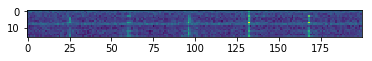

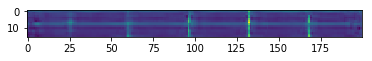

In [161]:
i = 13
np.set_printoptions(precision=3, suppress=True)
plt.figure()
plt.imshow(x_cluster_samp[i, :, :, 0])
plt.figure()
plt.imshow(recons[i, :, :, 0])
print(probs[i]*100)

In [ ]:
# Save Model
from datetime import datetime
timestamp = datetime.now().strftime("%d-%m-%y-%H:%M")
print("timestamp =", timestamp)

model_name = "cluster_model_64"
# serialize model to JSON
model_json = autoencoder.to_json()
with open(f"models/{model_name}-{timestamp}.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights(f"models/{model_name}-{timestamp}.h5")
print("Saved model to disk")

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Load Model
with open("models/cluster_model-16-04-20-15:46.json") as file:
    loaded_model_json = file.read()
autoencoder = keras.models.model_from_json(loaded_model_json)
autoencoder.load_weights("models/cluster_model-16-04-20-15:46.h5")
print("loaded model")

In [128]:
num_batch_each = 200
x_cluster_samp = np.empty((num_batch_each*len(dir_names)*32, 16, 200, 1))
y_cluster_samp = np.empty((num_batch_each*len(dir_names)*32))
for shift, directory in enumerate(dir_names):
    gen = datagen.flow_from_directory(
        directory=f"../../data/S-band/{directory}/filtered",
        target_size=(16, 200),
        color_mode="grayscale",
        class_mode="sparse"
    )
    for i in tqdm(range(num_batch_each)):
        temp_x, temp_y = gen.next()
        x_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_x
        y_cluster_samp[(shift*num_batch_each+i)*32:(shift*num_batch_each+i+1)*32] = temp_y

Found 48472 images belonging to 11 classes.







  0%|          | 0/200 [00:00<?, ?it/s]




  0%|          | 1/200 [00:04<14:53,  4.49s/it]




  1%|          | 2/200 [00:07<13:36,  4.12s/it]




  2%|▏         | 3/200 [00:08<10:16,  3.13s/it]




  2%|▏         | 4/200 [00:09<07:53,  2.42s/it]




  2%|▎         | 5/200 [00:10<06:26,  1.98s/it]




  3%|▎         | 6/200 [00:11<05:15,  1.63s/it]




  4%|▎         | 7/200 [00:11<04:30,  1.40s/it]




  4%|▍         | 8/200 [00:12<03:55,  1.23s/it]




  4%|▍         | 9/200 [00:13<03:33,  1.12s/it]




  5%|▌         | 10/200 [00:14<03:19,  1.05s/it]




  6%|▌         | 11/200 [00:15<03:12,  1.02s/it]




  6%|▌         | 12/200 [00:16<02:59,  1.05it/s]




  6%|▋         | 13/200 [00:17<02:56,  1.06it/s]




  7%|▋         | 14/200 [00:18<02:53,  1.07it/s]




  8%|▊         | 15/200 [00:19<02:55,  1.05it/s]




  8%|▊         | 16/200 [00:20<02:57,  1.04it/s]




  8%|▊         | 17/200 [00:21<03:01,  1.01it/s]




  9%|▉         | 18/200 [00:22<02:53,  1.05it/s]




 10%|▉

Found 66973 images belonging to 11 classes.







  0%|          | 0/200 [00:00<?, ?it/s]




  0%|          | 1/200 [00:01<03:46,  1.14s/it]




  1%|          | 2/200 [00:02<03:31,  1.07s/it]




  2%|▏         | 3/200 [00:02<03:09,  1.04it/s]




  2%|▏         | 4/200 [00:03<02:47,  1.17it/s]




  2%|▎         | 5/200 [00:03<02:27,  1.33it/s]




  3%|▎         | 6/200 [00:04<02:30,  1.29it/s]




  4%|▎         | 7/200 [00:05<02:25,  1.33it/s]




  4%|▍         | 8/200 [00:06<02:22,  1.35it/s]




  4%|▍         | 9/200 [00:06<02:12,  1.44it/s]




  5%|▌         | 10/200 [00:07<02:12,  1.43it/s]




  6%|▌         | 11/200 [00:08<02:19,  1.36it/s]




  6%|▌         | 12/200 [00:08<02:08,  1.47it/s]




  6%|▋         | 13/200 [00:09<02:00,  1.56it/s]




  7%|▋         | 14/200 [00:09<02:00,  1.55it/s]




  8%|▊         | 15/200 [00:10<02:01,  1.53it/s]




  8%|▊         | 16/200 [00:11<02:00,  1.53it/s]




  8%|▊         | 17/200 [00:12<02:05,  1.46it/s]




  9%|▉         | 18/200 [00:12<02:01,  1.50it/s]




 10%|▉

Found 70384 images belonging to 11 classes.







  0%|          | 0/200 [00:00<?, ?it/s]




  0%|          | 1/200 [00:00<02:30,  1.32it/s]




  1%|          | 2/200 [00:01<02:28,  1.34it/s]




  2%|▏         | 3/200 [00:02<02:20,  1.40it/s]




  2%|▏         | 4/200 [00:02<02:12,  1.48it/s]




  2%|▎         | 5/200 [00:03<02:02,  1.60it/s]




  3%|▎         | 6/200 [00:03<02:03,  1.58it/s]




  4%|▎         | 7/200 [00:04<02:10,  1.48it/s]




  4%|▍         | 8/200 [00:05<02:19,  1.38it/s]




  4%|▍         | 9/200 [00:06<02:16,  1.40it/s]




  5%|▌         | 10/200 [00:06<02:13,  1.42it/s]




  6%|▌         | 11/200 [00:07<02:10,  1.45it/s]




  6%|▌         | 12/200 [00:08<02:08,  1.47it/s]




  6%|▋         | 13/200 [00:08<02:09,  1.45it/s]




  7%|▋         | 14/200 [00:09<02:12,  1.40it/s]




  8%|▊         | 15/200 [00:10<02:13,  1.38it/s]




  8%|▊         | 16/200 [00:11<02:12,  1.39it/s]




  8%|▊         | 17/200 [00:12<02:21,  1.30it/s]




  9%|▉         | 18/200 [00:12<02:19,  1.30it/s]




 10%|▉

Found 76978 images belonging to 11 classes.







  0%|          | 0/200 [00:00<?, ?it/s]




  0%|          | 1/200 [00:00<02:59,  1.11it/s]




  1%|          | 2/200 [00:01<02:46,  1.19it/s]




  2%|▏         | 3/200 [00:02<02:36,  1.26it/s]




  2%|▏         | 4/200 [00:02<02:26,  1.34it/s]




  2%|▎         | 5/200 [00:03<02:19,  1.40it/s]




  3%|▎         | 6/200 [00:04<02:19,  1.39it/s]




  4%|▎         | 7/200 [00:04<02:18,  1.40it/s]




  4%|▍         | 8/200 [00:05<02:08,  1.49it/s]




  4%|▍         | 9/200 [00:06<02:07,  1.50it/s]




  5%|▌         | 10/200 [00:06<02:02,  1.56it/s]




  6%|▌         | 11/200 [00:07<02:06,  1.50it/s]




  6%|▌         | 12/200 [00:08<02:00,  1.56it/s]




  6%|▋         | 13/200 [00:08<01:54,  1.63it/s]




  7%|▋         | 14/200 [00:09<01:56,  1.60it/s]




  8%|▊         | 15/200 [00:09<01:55,  1.60it/s]




  8%|▊         | 16/200 [00:10<01:52,  1.63it/s]




  8%|▊         | 17/200 [00:11<01:45,  1.73it/s]




  9%|▉         | 18/200 [00:11<01:38,  1.84it/s]




 10%|▉

In [129]:
encoder = Model(inputs=idec.input, outputs=idec.get_layer("encoded").output)

In [36]:
from sklearn import manifold
import matplotlib.colors as mcolors
color_set = mcolors.TABLEAU_COLORS
cnames = list(color_set.keys())

In [162]:
encoded_samp = encoder.predict(x_cluster_samp)
probs, recons = idec.predict(x_cluster_samp)

In [163]:
tsne = manifold.TSNE(n_components=2, init='random', perplexity=100, n_jobs=-1, verbose=1)
embedded_samp = tsne.fit_transform(encoded_samp)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 25600 samples in 0.682s...
[t-SNE] Computed neighbors for 25600 samples in 5.855s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25600
[t-SNE] Computed conditional probabilities for sample 2000 / 25600
[t-SNE] Computed conditional probabilities for sample 3000 / 25600
[t-SNE] Computed conditional probabilities for sample 4000 / 25600
[t-SNE] Computed conditional probabilities for sample 5000 / 25600
[t-SNE] Computed conditional probabilities for sample 6000 / 25600
[t-SNE] Computed conditional probabilities for sample 7000 / 25600
[t-SNE] Computed conditional probabilities for sample 8000 / 25600
[t-SNE] Computed conditional probabilities for sample 9000 / 25600
[t-SNE] Computed conditional probabilities for sample 10000 / 25600
[t-SNE] Computed conditional probabilities for sample 11000 / 25600
[t-SNE] Computed conditional probabilities for sample 12000 / 25600
[t-SNE] Computed conditional probabilities for sa

In [169]:
threshold = 0.8
np.count_nonzero(np.max(probs, axis=1) > threshold)

16861

In [170]:
y_pred = np.argmax(probs, axis=1)
y_pred[np.max(probs, axis=1) < threshold] = -1

In [203]:
embedded_samp_plot = embedded_samp[(y_pred < 11) * (y_pred != -1)]
y_pred_plot = y_pred[(y_pred < 11) * (y_pred != -1)]

In [204]:
pred_counts = {}
for class_ind in np.unique(y_pred):
    pred_counts[class_ind] = np.count_nonzero(y_pred == class_ind)
pred_counts

{-1: 8739, 0: 8690, 2: 1524, 4: 1485, 5: 1330, 6: 1329, 7: 832, 10: 1671}

In [205]:
list(enumerate(cnames))

[(0, 'tab:blue'),
 (1, 'tab:orange'),
 (2, 'tab:green'),
 (3, 'tab:red'),
 (4, 'tab:purple'),
 (5, 'tab:brown'),
 (6, 'tab:pink'),
 (7, 'tab:gray'),
 (8, 'tab:olive'),
 (9, 'tab:cyan'),
 (10, 'tab:red')]

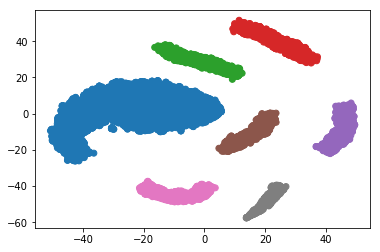

In [206]:
# 2D
embedded_x, embedded_y = np.split(embedded_samp_plot, 2, axis=1)
plt.scatter(embedded_x, embedded_y, c=[cnames[e] for e in y_pred_plot])

# # 3D
# fig = plt.figure()
# ax = plt.axes(projection='3d')

# embedded_x, embedded_y, embedded_z = np.split(embedded_samp, 3, axis=1)
# ax.scatter3D(embedded_x, embedded_y, embedded_z)

In [178]:
inds = np.arange(y_pred.shape[0])[y_pred == 0]

/usr/local/lib/python3.6/dist-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


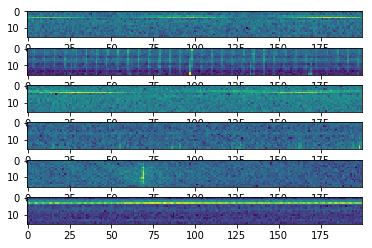

In [179]:
sample_inds = np.random.choice(inds, size=6)
figure, axes = plt.subplots(nrows=6, ncols=1)
plt.subplot(611)
plt.imshow(x_cluster_samp[sample_inds[0], :, :, 0])
plt.subplot(612)
plt.imshow(x_cluster_samp[sample_inds[1], :, :, 0])
plt.subplot(613)
plt.imshow(x_cluster_samp[sample_inds[2], :, :, 0])
plt.subplot(614)
plt.imshow(x_cluster_samp[sample_inds[3], :, :, 0])
plt.subplot(615)
plt.imshow(x_cluster_samp[sample_inds[4], :, :, 0])
plt.subplot(616)
plt.imshow(x_cluster_samp[sample_inds[5], :, :, 0])
figure.tight_layout(pad=3.0)

In [180]:
import pandas as pd

In [181]:
gen = datagen.flow_from_directory(
    directory=f"../../data/S-band/GBT_58210_37805_HIP103730_fine/filtered",
    target_size=(16, 200),
    color_mode="grayscale",
    class_mode="input",
    shuffle=False
)

Found 70384 images belonging to 11 classes.


In [182]:
x_single_file_samp = np.empty((1000*32, 16, 200, 1))
filenames = []
for i in tqdm(range(1000)):
        temp_x, temp_y = gen.next()
        x_single_file_samp[(i)*32:(i+1)*32] = temp_x
        idx = (gen.batch_index - 1) * gen.batch_size
        filenames.extend(gen.filenames[idx : idx + gen.batch_size])







  0%|          | 0/1000 [00:00<?, ?it/s]




  0%|          | 1/1000 [00:00<02:33,  6.53it/s]




  0%|          | 2/1000 [00:00<02:22,  7.00it/s]




  0%|          | 4/1000 [00:00<02:03,  8.07it/s]




  1%|          | 6/1000 [00:00<01:51,  8.95it/s]




  1%|          | 9/1000 [00:00<01:28, 11.23it/s]




  1%|          | 12/1000 [00:00<01:13, 13.50it/s]




  2%|▏         | 15/1000 [00:00<01:03, 15.53it/s]




  2%|▏         | 18/1000 [00:01<00:54, 17.90it/s]




  2%|▏         | 22/1000 [00:01<00:47, 20.59it/s]




  2%|▎         | 25/1000 [00:01<00:43, 22.34it/s]




  3%|▎         | 29/1000 [00:01<00:40, 24.13it/s]




  3%|▎         | 32/1000 [00:01<00:42, 22.96it/s]




  4%|▎         | 36/1000 [00:01<00:37, 25.75it/s]




  4%|▍         | 39/1000 [00:01<00:35, 26.86it/s]




  4%|▍         | 43/1000 [00:01<00:33, 28.62it/s]




  5%|▍         | 47/1000 [00:02<00:32, 29.13it/s]




  5%|▌         | 51/1000 [00:02<00:39, 24.20it/s]




  5%|▌         | 54/1000 [00:02<00:38

 32%|███▎      | 325/1000 [00:18<01:52,  6.02it/s]




 33%|███▎      | 326/1000 [00:18<01:55,  5.85it/s]




 33%|███▎      | 327/1000 [00:19<01:47,  6.27it/s]




 33%|███▎      | 328/1000 [00:19<02:14,  4.99it/s]




 33%|███▎      | 329/1000 [00:19<02:10,  5.16it/s]




 33%|███▎      | 330/1000 [00:19<02:01,  5.53it/s]




 33%|███▎      | 331/1000 [00:19<02:06,  5.28it/s]




 33%|███▎      | 332/1000 [00:20<02:12,  5.05it/s]




 33%|███▎      | 333/1000 [00:20<01:54,  5.83it/s]




 33%|███▎      | 334/1000 [00:20<01:43,  6.41it/s]




 34%|███▎      | 335/1000 [00:20<01:33,  7.08it/s]




 34%|███▎      | 337/1000 [00:20<01:22,  8.03it/s]




 34%|███▍      | 339/1000 [00:20<01:13,  9.02it/s]




 34%|███▍      | 341/1000 [00:20<01:10,  9.41it/s]




 34%|███▍      | 343/1000 [00:21<01:03, 10.39it/s]




 34%|███▍      | 345/1000 [00:21<01:05, 10.08it/s]




 35%|███▍      | 347/1000 [00:21<01:19,  8.22it/s]




 35%|███▍      | 349/1000 [00:21<01:13,  8.91it/s]




 35%|███▌ 

 48%|████▊     | 482/1000 [00:39<00:49, 10.54it/s]




 48%|████▊     | 484/1000 [00:40<00:54,  9.44it/s]




 49%|████▊     | 486/1000 [00:40<00:53,  9.66it/s]




 49%|████▉     | 488/1000 [00:40<01:00,  8.50it/s]




 49%|████▉     | 489/1000 [00:40<01:00,  8.51it/s]




 49%|████▉     | 490/1000 [00:41<01:04,  7.96it/s]




 49%|████▉     | 491/1000 [00:41<01:04,  7.85it/s]




 49%|████▉     | 492/1000 [00:41<01:06,  7.68it/s]




 49%|████▉     | 494/1000 [00:41<00:54,  9.25it/s]




 50%|████▉     | 496/1000 [00:41<00:50, 10.02it/s]




 50%|████▉     | 498/1000 [00:41<00:46, 10.81it/s]




 50%|█████     | 500/1000 [00:41<00:41, 12.12it/s]




 50%|█████     | 502/1000 [00:42<00:54,  9.20it/s]




 50%|█████     | 504/1000 [00:42<00:45, 10.86it/s]




 51%|█████     | 507/1000 [00:42<00:38, 12.95it/s]




 51%|█████     | 509/1000 [00:42<00:44, 10.96it/s]




 51%|█████     | 511/1000 [00:42<00:52,  9.30it/s]




 51%|█████▏    | 513/1000 [00:43<00:54,  8.96it/s]




 52%|█████

 64%|██████▍   | 638/1000 [01:02<00:51,  6.97it/s]




 64%|██████▍   | 639/1000 [01:03<01:03,  5.65it/s]




 64%|██████▍   | 640/1000 [01:03<01:00,  5.93it/s]




 64%|██████▍   | 642/1000 [01:03<00:58,  6.09it/s]




 64%|██████▍   | 643/1000 [01:03<00:56,  6.35it/s]




 64%|██████▍   | 644/1000 [01:03<00:53,  6.62it/s]




 64%|██████▍   | 645/1000 [01:03<00:49,  7.21it/s]




 65%|██████▍   | 646/1000 [01:04<00:52,  6.78it/s]




 65%|██████▍   | 647/1000 [01:04<00:51,  6.87it/s]




 65%|██████▍   | 648/1000 [01:04<00:50,  6.98it/s]




 65%|██████▍   | 649/1000 [01:04<01:02,  5.61it/s]




 65%|██████▌   | 650/1000 [01:04<00:55,  6.32it/s]




 65%|██████▌   | 651/1000 [01:04<00:59,  5.82it/s]




 65%|██████▌   | 653/1000 [01:05<00:56,  6.13it/s]




 65%|██████▌   | 654/1000 [01:05<00:55,  6.19it/s]




 66%|██████▌   | 655/1000 [01:05<00:57,  5.99it/s]




 66%|██████▌   | 656/1000 [01:05<01:10,  4.90it/s]




 66%|██████▌   | 657/1000 [01:06<01:10,  4.86it/s]




 66%|█████

 80%|███████▉  | 797/1000 [01:24<00:53,  3.77it/s]




 80%|███████▉  | 798/1000 [01:24<00:43,  4.62it/s]




 80%|████████  | 800/1000 [01:25<00:39,  5.03it/s]




 80%|████████  | 801/1000 [01:25<00:46,  4.27it/s]




 80%|████████  | 802/1000 [01:25<00:53,  3.72it/s]




 80%|████████  | 803/1000 [01:26<00:50,  3.88it/s]




 80%|████████  | 804/1000 [01:26<00:49,  3.97it/s]




 80%|████████  | 805/1000 [01:26<00:49,  3.93it/s]




 81%|████████  | 806/1000 [01:26<00:45,  4.31it/s]




 81%|████████  | 807/1000 [01:26<00:38,  5.07it/s]




 81%|████████  | 808/1000 [01:27<00:35,  5.38it/s]




 81%|████████  | 809/1000 [01:27<00:35,  5.36it/s]




 81%|████████  | 810/1000 [01:27<00:37,  5.10it/s]




 81%|████████  | 812/1000 [01:27<00:34,  5.38it/s]




 81%|████████▏ | 813/1000 [01:27<00:37,  4.97it/s]




 81%|████████▏ | 814/1000 [01:28<00:35,  5.19it/s]




 82%|████████▏ | 816/1000 [01:28<00:34,  5.41it/s]




 82%|████████▏ | 817/1000 [01:28<00:36,  5.07it/s]




 82%|█████

 98%|█████████▊| 976/1000 [01:47<00:04,  4.95it/s]




 98%|█████████▊| 977/1000 [01:47<00:04,  4.92it/s]




 98%|█████████▊| 978/1000 [01:47<00:05,  3.79it/s]




 98%|█████████▊| 979/1000 [01:47<00:04,  4.52it/s]




 98%|█████████▊| 980/1000 [01:48<00:04,  4.54it/s]




 98%|█████████▊| 981/1000 [01:48<00:04,  4.35it/s]




 98%|█████████▊| 982/1000 [01:48<00:04,  3.82it/s]




 98%|█████████▊| 983/1000 [01:48<00:03,  4.47it/s]




 98%|█████████▊| 984/1000 [01:49<00:03,  5.15it/s]




 98%|█████████▊| 985/1000 [01:49<00:02,  5.72it/s]




 99%|█████████▊| 986/1000 [01:49<00:02,  6.18it/s]




 99%|█████████▊| 987/1000 [01:49<00:01,  6.67it/s]




 99%|█████████▉| 989/1000 [01:49<00:01,  7.04it/s]




 99%|█████████▉| 991/1000 [01:49<00:01,  7.20it/s]




 99%|█████████▉| 992/1000 [01:50<00:01,  6.94it/s]




 99%|█████████▉| 994/1000 [01:50<00:00,  6.65it/s]




100%|█████████▉| 995/1000 [01:50<00:00,  5.88it/s]




100%|█████████▉| 996/1000 [01:50<00:00,  5.87it/s]




100%|█████

In [183]:
df = pd.read_pickle("../../data/S-band/GBT_58210_37805_HIP103730_fine/info_df.pkl")
df = df.set_index("index")
df.sort_index()

,statistic,pvalue,block_num,freqs
index,,,,
1800,2162.035628,0.0,0,1926.264502
1900,2191.704729,0.0,0,1926.264223
2000,2112.150882,0.0,0,1926.263943
2200,2141.541252,0.0,0,1926.263385
2300,2157.209735,0.0,0,1926.263105
...,...,...,...,...
322225332,3028.179686,0.0,10,1025.982354
322225432,2997.248630,0.0,10,1025.982074
322225532,3684.330860,0.0,10,1025.981795


In [184]:
get_ind = lambda name: int(name.split("/")[1].split(".")[0])

In [185]:
frequencies = np.array([df.loc[get_ind(name)]["freqs"] for name in filenames])

In [186]:
probs, recons = idec.predict(x_single_file_samp)

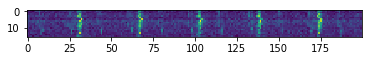

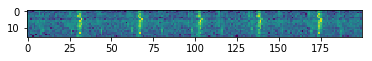

In [187]:
# check that filenames match
test_im = plt.imread(f"../../data/S-band/GBT_58210_37805_HIP103730_fine/filtered/{filenames[0]}")
plt.figure()
plt.imshow(test_im)
plt.figure()
plt.imshow(x_single_file_samp[0, :, :, 0])

In [188]:
preds = np.argmax(probs, axis=1)
preds.shape, frequencies.shape

((32000,), (32000,))

In [192]:
plt_frequencies = []
for i in range(0, 11):
    if len(frequencies[preds==i]) > 0:
        plt_frequencies.append(frequencies[preds==i])

In [193]:
len(plt_frequencies)

7

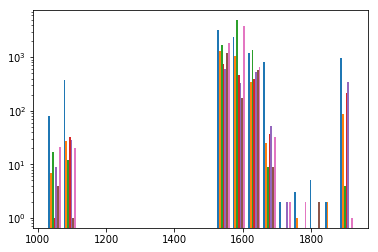

In [194]:
h = plt.hist(plt_frequencies, bins=20, range=(np.min(frequencies), np.max(frequencies)))
plt.yscale("log")

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [ ]:
scaled_samp = StandardScaler().fit_transform(encoded_samp)

In [ ]:
db = DBSCAN(eps=0.5, min_samples=6).fit(scaled_samp)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

In [ ]:
print(len(labels))

In [ ]:
inds = np.where(labels==1)[0]
print(f"Number of samples: {len(inds)}")

In [ ]:
sample_inds = np.random.choice(inds, size=6)
figure, axes = plt.subplots(nrows=6, ncols=1)
plt.subplot(611)
plt.imshow(sample[sample_inds[0], :, :, 0])
plt.subplot(612)
plt.imshow(sample[sample_inds[1], :, :, 0])
plt.subplot(613)
plt.imshow(sample[sample_inds[2], :, :, 0])
plt.subplot(614)
plt.imshow(sample[sample_inds[3], :, :, 0])
plt.subplot(615)
plt.imshow(sample[sample_inds[4], :, :, 0])
plt.subplot(616)
plt.imshow(sample[sample_inds[5], :, :, 0])
figure.tight_layout(pad=3.0)